In [ ]:
!pip install datasets
!pip install pinecone-text
!pip install pinecone-client
!pip install huggingface_hub
!pip install sentence-transformers

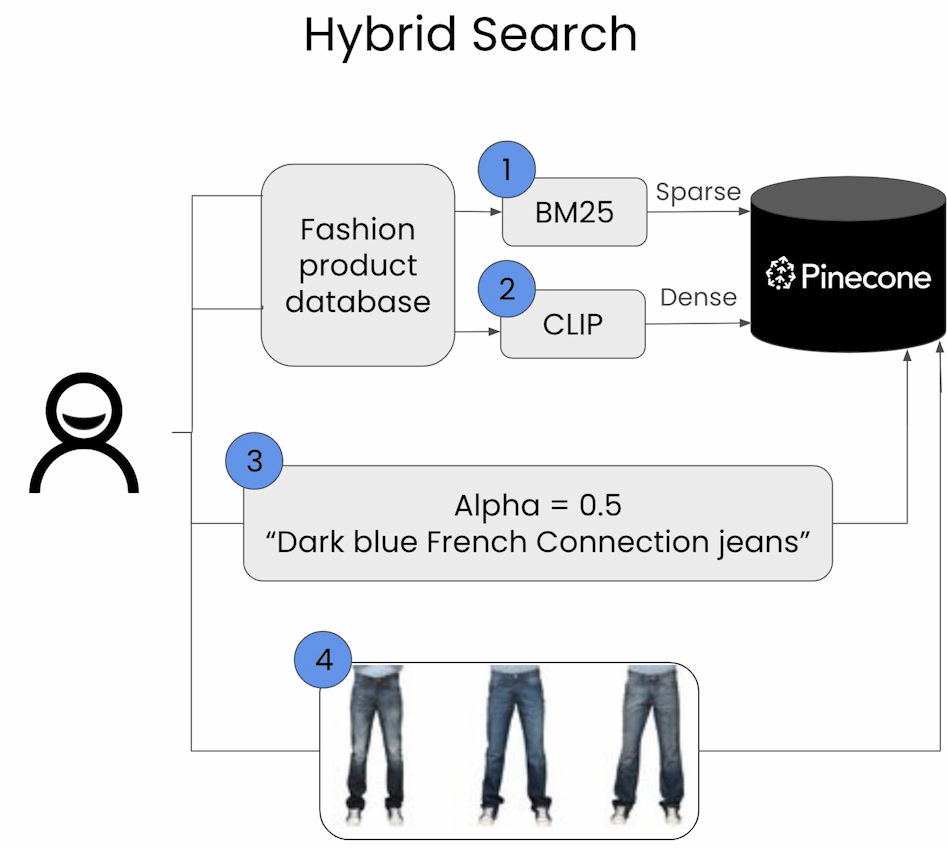

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [37]:
# basics
import os
import ast
import json
import requests
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# Plots and images
from PIL import Image
from io import BytesIO
from base64 import b64encode
import matplotlib.pyplot as plt
from IPython.core.display import HTML

# API access
from google.colab import userdata

# Huggingface
import torch
import transformers
from datasets import load_dataset
from huggingface_hub import login

# data & DB
from google.colab import userdata
from pinecone_text.sparse import BM25Encoder
from pinecone import Pinecone, ServerlessSpec
from sentence_transformers import SentenceTransformer

### Setting up Vector DB (Pinecone)

In [27]:
# setting up pinecone.
device = "cuda" if torch.cuda.is_available() else "cpu"
if device != "cuda":
    print("GPU not available")
    print('=' * 50)
else:
    print("GPU available\n\n")
    print('=' * 50)

# access pinecone apikey
pinecone = Pinecone(api_key=userdata.get("PINECONE_API_KEY"))
INDEX_NAME = "hybrid-search-data-index"

# delete existing index, if exists
if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
    print(f"Index {INDEX_NAME} already exists")
    print('=' * 50)
    pinecone.delete_index(INDEX_NAME)
    print(f"Index {INDEX_NAME} deleted")
else:
    print(f"Index {INDEX_NAME} does not exist")

GPU not available
Index hybrid-search-data-index already exists
Index hybrid-search-data-index deleted


In [28]:
# Create a new index with the specified name, dimension, and metric
pinecone.create_index(
    name=INDEX_NAME,
    dimension= 512,  # model embedding dimensions
    metric="dotproduct",  # search metric
    spec=ServerlessSpec(cloud="aws", region="us-east-1")
)

pinecone_index = pinecone.Index(INDEX_NAME)
print(f'Index Created: \n----------------------------\n{INDEX_NAME}\n----------------------------')
print(pinecone_index)

Index Created: 
----------------------------
hybrid-search-data-index
----------------------------


### Loading Fashion Data

In [ ]:
fashion = load_dataset(
    "ashraq/fashion-product-images-small",
    split="train")

fashion

id 
----------> 33222 

gender 
----------> Women 

masterCategory 
----------> Apparel 

subCategory 
----------> Topwear 

articleType 
----------> Tunics 

baseColour 
----------> Brown 

season 
----------> Summer 

year 
----------> 2012.0 

usage 
----------> Casual 

productDisplayName 
----------> Sepia Women Brown Tunic 

image 
----------> <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7E647694B430> 



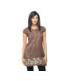

In [7]:
for index, value in fashion[900].items():
    print(index, '\n---------->', value,'\n')
    if index == 'image':  # Check if the current item is the image
        # Retrieve image dimensions
        width, height = value.size
        # Set the figure size to match the image dimensions
        plt.figure(figsize=(width / 100, height / 100))
        plt.imshow(value)  # Display the image
        plt.axis('off')  # Hide the axes
        plt.show()

In [8]:
images = fashion['image']
metadata = fashion.remove_columns('image')

In [9]:
# convert metadata to pandas df
metadata = metadata.to_pandas()
metadata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [10]:
# sanity check!
print(len(images), metadata.shape[0])

44072 44072


### Creating Sparse Vector using BM25

In [ ]:
bm25 = BM25Encoder()
bm25.fit(metadata['productDisplayName'])
metadata['productDisplayName'][0]

In [12]:
bm25.encode_queries(metadata['productDisplayName'][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.3276687848622804,
  0.19377339510596148,
  0.040475545164610806,
  0.1808640794607714,
  0.10791423980552016,
  0.1493039556008558]}

In [13]:
bm25.encode_documents(metadata['productDisplayName'][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887]}

Creating Dense Vector Using CLIP

In [ ]:
model = SentenceTransformer('sentence-transformers/clip-ViT-B-32',
    device=device)
model
dense_vec = model.encode([metadata['productDisplayName'][0]])
dense_vec.shape

In [18]:
len(fashion)


44072

In [32]:
# Define the batch size for processing
batch_size = 50

# Loop over the first 1000 samples in batches of 50
for i in tqdm(range(0, 1000, batch_size)):
    # Ensures that i_end does not exceed the length of the subset
    i_end = min(i + batch_size, 1000)

    # Extract metadata batch
    meta_batch = metadata.iloc[i:i_end]

    # Convert to dictionary
    meta_dict = meta_batch.to_dict(orient="records")

    # Select all columns except 'id' and 'year' from the DataFrame 'meta_batch'
    selected_columns = meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])]

    # Convert the selected columns (DataFrame) to a list of lists
    list_of_lists = selected_columns.values.tolist()

    # Initialize an empty list to store the concatenated strings
    concatenated_strings = []

    # Loop through each row in the list of lists
    for row in list_of_lists:
        # Join the values in the row into a single string with a space as the separator
        concatenated_string = " ".join(map(str, row))
        # Add the concatenated string to the list
        concatenated_strings.append(concatenated_string)

    # Assign the list of concatenated strings back to 'meta_batch'
    meta_batch = concatenated_strings

    # Extract image batch
    img_batch = images[i:i_end]

    # Create sparse BM25 vectors
    try:
        sparse_embeds = bm25.encode_documents(meta_batch)
    except Exception as e:
        print(f"Error encoding documents with BM25: {e}")
        continue

    # Create dense vectors
    try:
        dense_embeds = model.encode(img_batch).tolist()
    except Exception as e:
        print(f"Error encoding images: {e}")
        continue

    # Create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    # Loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })

    # Upload the documents to the new hybrid index
    try:
        pinecone_index.upsert(upserts)
    except Exception as e:
        print(f"Error upserting to Pinecone: {e}")

# Show index description after uploading the documents
try:
    index_stats = pinecone_index.describe_index_stats()
    print(index_stats)
except Exception as e:
    print(f"Error describing index stats: {e}")


100%|██████████| 20/20 [03:36<00:00, 10.82s/it]

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 1000}},
 'total_vector_count': 1000}


### Check Queries!

In [ ]:
# function to display product images
def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')

In [34]:
# define the query
query = "dark blue french connection jeans for men"
# embed the query
sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()

result = pinecone_index.query(
    top_k=14,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)

imgs = [images[int(r["id"])] for r in result["matches"]]
imgs

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.Image.Image image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.Image.Image image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>]


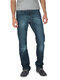
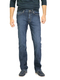
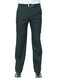
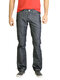
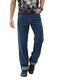
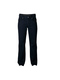
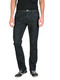
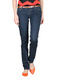
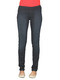
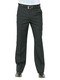
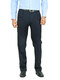
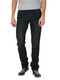
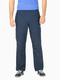
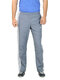

In [36]:
display_result(imgs)

### Scaling Search

In [38]:
def hybrid_scale(dense, sparse, alpha: float):
    """Hybrid vector scaling using a convex combination

    alpha * dense + (1 - alpha) * sparse

    Args:
        dense: Array of floats representing
        sparse: a dict of `indices` and `values`
        alpha: float between 0 and 1 where 0 == sparse only
               and 1 == dense only
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse

### More Dense Search


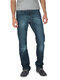
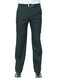
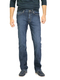
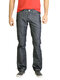
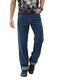
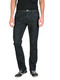

In [40]:
question = "dark blue french connection jeans for men"
#Closer to 0==more sparse, closer to 1==more dense
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
result = pinecone_index.query(
    top_k=6,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)

In [41]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Peter England Men Party Blue Jeans
John Miller Men Reglur Black Trousers
Lee Men Blue Chicago Fit Jeans
Locomotive Men Washed Blue Jeans
Lee Men Blue Chicago Fit Jeans
Peter England Men Black Jeans


### More Sparse Search


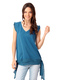
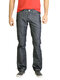
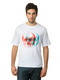
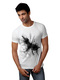
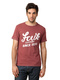
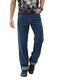

In [43]:
question = "dark blue french connection jeans for men"
#Closer to 0==more sparse, closer to 1==more dense
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
result = pinecone_index.query(
    top_k=6,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)

In [44]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

French Connection Women Blue Top
Locomotive Men Washed Blue Jeans
French Connection Men White T-shirt
French Connection Men White T-shirt
French Connection Men Maroon T-shirt
Lee Men Blue Chicago Fit Jeans


### Sparse and Dense


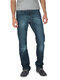
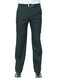
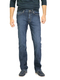
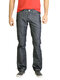
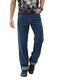
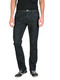

In [46]:
question = "dark blue french connection jeans for men"
#Closer to 0==more sparse, closer to 1==more dense
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
result = pinecone_index.query(
    top_k=6,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
imgs = [images[int(r["id"])] for r in result["matches"]]
display_result(imgs)

In [47]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Peter England Men Party Blue Jeans
John Miller Men Reglur Black Trousers
Lee Men Blue Chicago Fit Jeans
Locomotive Men Washed Blue Jeans
Lee Men Blue Chicago Fit Jeans
Peter England Men Black Jeans
